In [28]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
Pkg.instantiate()

using ForwardDiff
using LinearAlgebra
using Statistics
using Plots
plotlyjs()
using Printf
using Random
using DifferentialEquations

  Activating project at `/home/sman/Work/CMU/Courses/OCRL/OCRL-Walker-Project/juliaImplementation/juliaImplementation`


In [29]:
const FD = ForwardDiff;

PLOTS_DEFAULTS = Dict(:dpi => 600);

include("GeneralizedFunctionality/est_parameters.jl");
include("GeneralizedFunctionality/hybrid_system_simulation_tools.jl")
include("GeneralizedFunctionality/SKF_general.jl")
include("GeneralizedFunctionality/batch_estimation.jl")
include("GeneralizedFunctionality/generalized_saltation_calculations.jl")
include("DynamicSystems/bouncing_ball.jl") # Defines hybrid system functions
include("DynamicSystems/biped.jl") # Defines hybrid system functions

#Falling ball system definition
# dynamics = [balldynamics,balldynamics]
dynamics = [biped_dynamics_3link,biped_dynamics_2link]
resets = [[idReset,kneeReset],[heelReset,idReset]]
guards = [[idGuard,kneeGuard],[heelGuard,idGuard]]

2-element Vector{Vector{Function}}:
 [idGuard, kneeGuard]
 [heelGuard, idGuard]

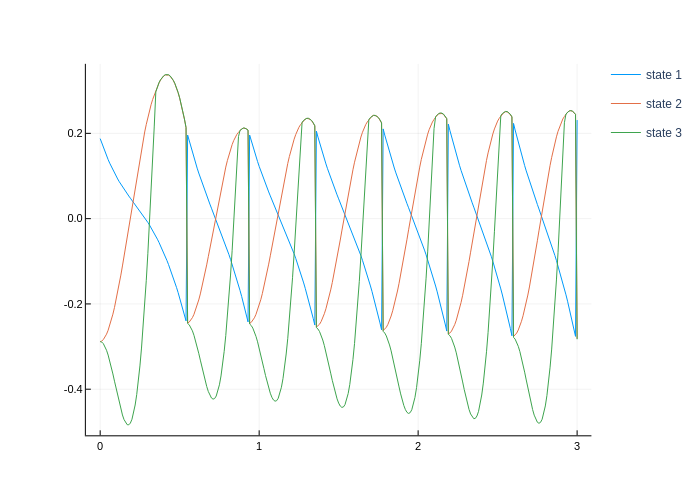

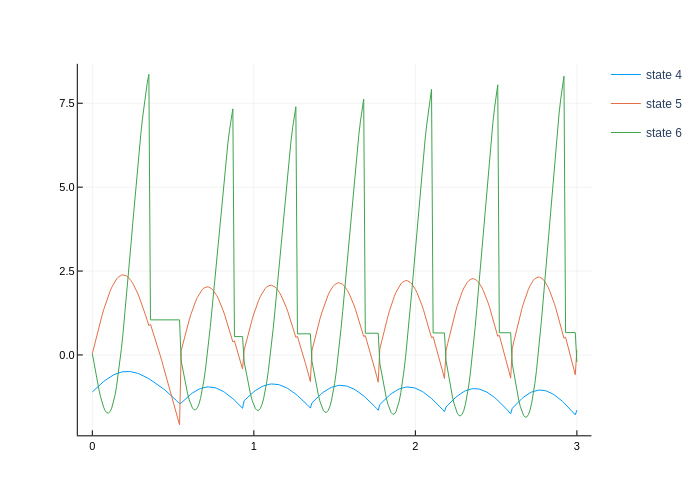

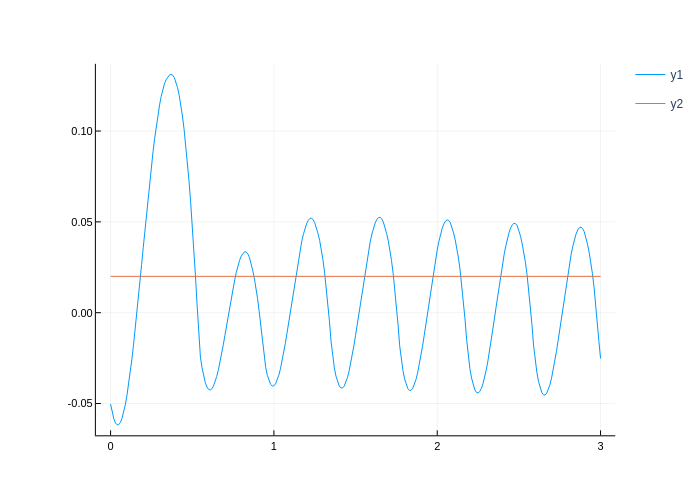

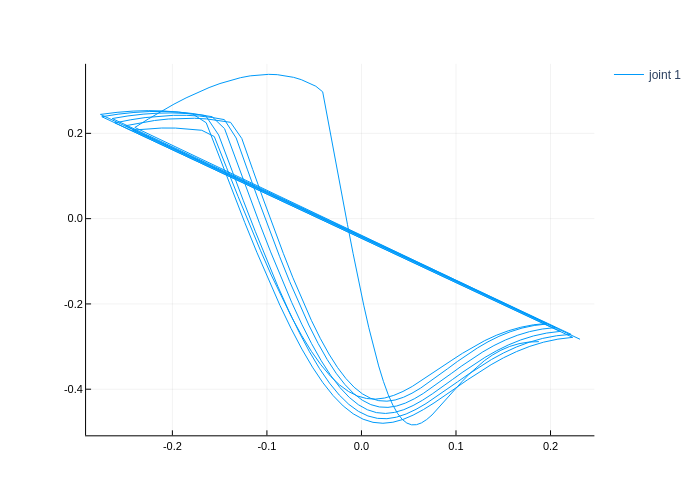

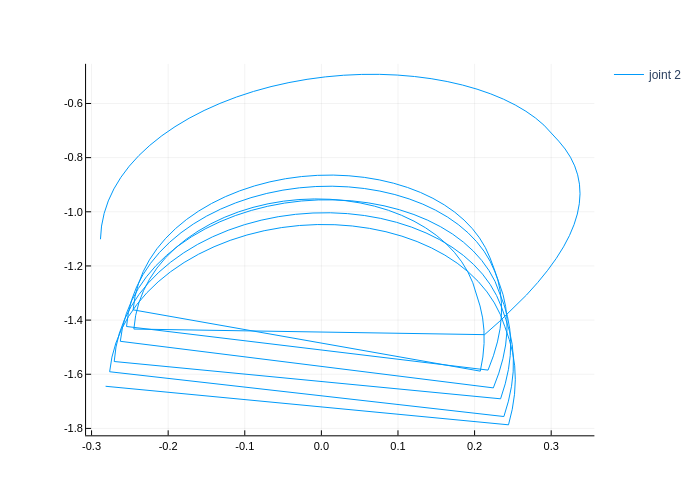

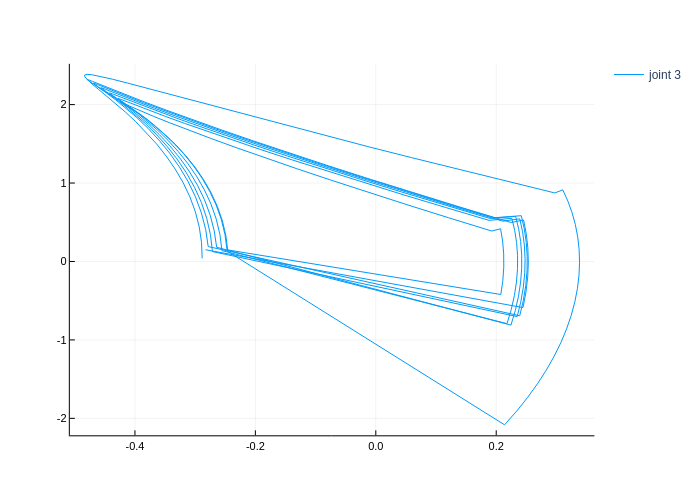

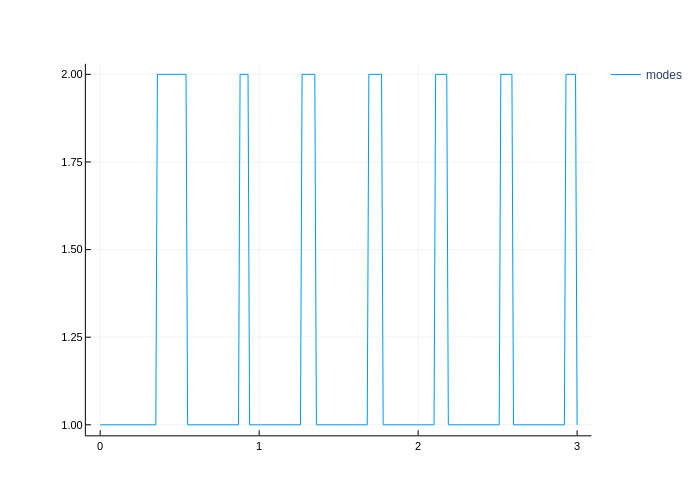

┌ Info: Saved animation to 
│   fn = /home/sman/Work/CMU/Courses/OCRL/OCRL-Walker-Project/juliaImplementation/juliaImplementation/src/walker.gif
└ @ Plots /root/.julia/packages/Plots/NQpB8/src/animation.jl:114


Plots.AnimatedGif("/home/sman/Work/CMU/Courses/OCRL/OCRL-Walker-Project/juliaImplementation/juliaImplementation/src/walker.gif")
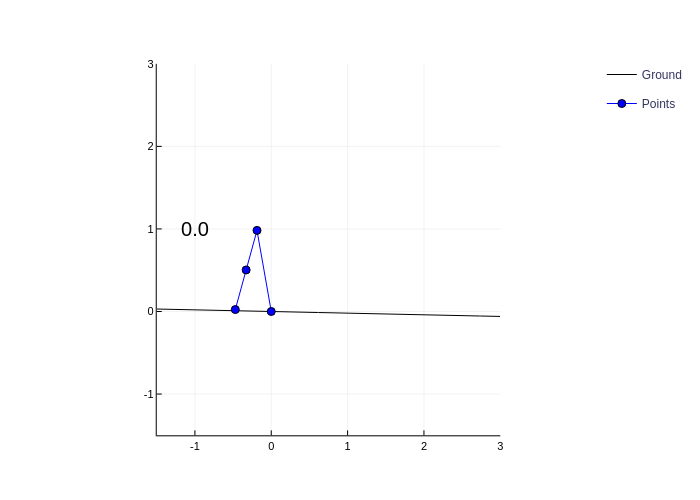

In [30]:
mode0 = 1
t = 3.0
dt = .01

q1 = 0.1877
q2 = -0.2884
q3 = q2
q̇1 = -1.1014
q̇2 = 0.0399
q̇3 = q̇2

xmean = [q1, q2, q3, q̇1, q̇2, q̇3]

p = (L = 1, a1 = 0.375, b1 = 0.125, a2 = 0.175, b2 = 0.375, mH = 0.5, mt = 0.5, ms = 0.05, g = 9.81, slope = 0.02)

#Nominal Trajectory
nom_states, _, times, nom_modes,nom_impact_states,_ = sim_system(xmean,mode0,dynamics,resets,guards,0,0,0,t,dt)
state_matrix = hcat(nom_states...)

plot()
[plot!(times,state_matrix[i,:], label = "state $i") for i in 1:3]
display(plot!())

plot()
[plot!(times,state_matrix[i,:], label = "state $i") for i in 4:6]
display(plot!())

plot(times, (state_matrix[1,:] .+ state_matrix[2,:])/2)
plot!(times, ones(size(times)) * p.slope)
display(plot!())

for i = 1:3
    plot()
    plot(state_matrix[i,:], state_matrix[i+2,:], label = "joint $i")
    display(plot!())
end

plot(times, nom_modes, label = "modes")
display(plot!())

slope = p.slope

# Initialize an Animation objects
anim = Animation()
lim = 1.5

timesteps = size(state_matrix,2)

j1 = [0,0]
# Loop to create frames
for i in 1:timesteps

    if i > 1 && nom_modes[i] == 1 && nom_modes[i-1] == 2
        j1 = q2joints(state_matrix[:,i-1], j1)[end]
    end

    js = hcat(q2joints(state_matrix[:,i], j1)...)
    # Plot the data
    l_bound = -lim
    r_bound = 2*lim

    xs = l_bound:0.01:r_bound
    ys = -slope * xs
    plot(xs, ys, linestyle=:solid, label="Ground", color="black")
    plot!(js[1,:], js[2,:], xlim=(l_bound,r_bound),
                            ylim=(l_bound,r_bound), 
                            label="Points", 
                            color="blue", 
                            linestyle=:solid, 
                            marker=:circle, 
                            aspect_ratio=:equal)
    annotate!(-1, 1, times[i], color=:red)
    # Add frame to animation
    frame(anim)
end
# Save the animation as a gif
gif(anim, "walker.gif", fps = 30)